---
# 0. 라이브러리
----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
from collections import Counter

In [3]:
cd /content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/

/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data


---
# 1. Data
----

In [4]:
class Config():
  train = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/train.csv'
  test = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/test.csv'
  sub = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sample_submission.csv'
  epoch = 100
  num_worker = 5
  lr = 1e-4
  sr = 16000
  batch_size = 64


config = Config()

In [5]:
train = pd.read_csv(config.train)
test = pd.read_csv(config.test)
train

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


---
# 2. Preprocessing
---

In [6]:
# 각 오디오 파일에 대한 평균 Mel-spectogram feature 계산
def get_feature_mel(df):
    features = []
    for i in tqdm(df['SAMPLE_PATH']):
        data, sr = librosa.load(i, 16000)
        n_fft = 2048 # 퓨리에 변환에 사용되는 창의 크기
        win_length = 2048 # 창의 길이
        hop_length = 1024 # 프레임 사이의 단계 크기 
        n_mels = 128 # 생성할 Mel의 주파수 대역의 수

        # 오디오 신호의 short-time Fourier transform(stft)을 계산
        D = np.abs(librosa.stft(data, n_fft=n_fft, win_length = win_length, hop_length=hop_length))

        # stft 크기의 멜 스펙토그램 프로그램을 계산
                                                  # sr = 오디오 파일의 샘플링 속도
        mel = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

    
        m_mel = mel.mean(axis=1) # 각 파일에 대한 평균을 계산
        features.append(m_mel)
    return np.array(features)

In [7]:
def get_feature_mfcc(df):
    features = []
    for i in tqdm(df['SAMPLE_PATH']):
        data, sr = librosa.load(i, 16000)
 
        mfcc = librosa.feature.mfcc(data, sr=sr, n_mfcc=128)
    
        m_mfcc = mfcc.mean(axis=1)
        features.append(m_mfcc)
    return np.array(features)

In [8]:
# mel
mel_train = get_feature_mel(train)
mel_test = get_feature_mel(test)

# mfcc 
mfcc_train = get_feature_mfcc(train)
mfcc_test = get_feature_mfcc(test)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

In [9]:
train.iloc[:,2]

0       2
1       0
2       0
3       2
4       2
       ..
1274    2
1275    2
1276    2
1277    2
1278    0
Name: FAN_TYPE, Length: 1279, dtype: int64

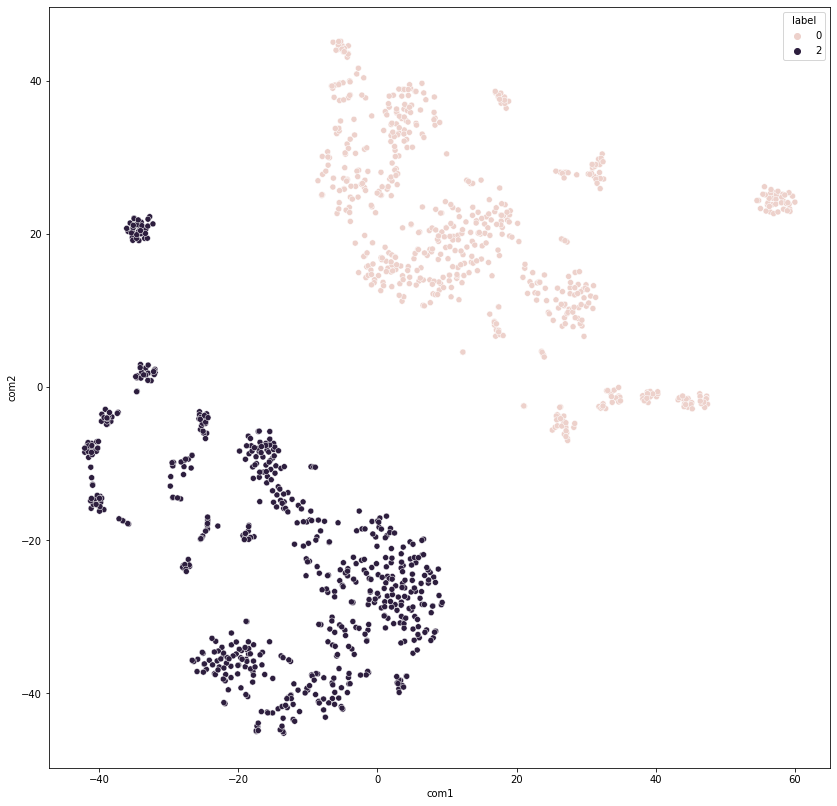

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tt = tsne.fit_transform(mel_train)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train.iloc[:,2]

sns.set_palette('deep')
plt.figure(figsize=(14,14))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

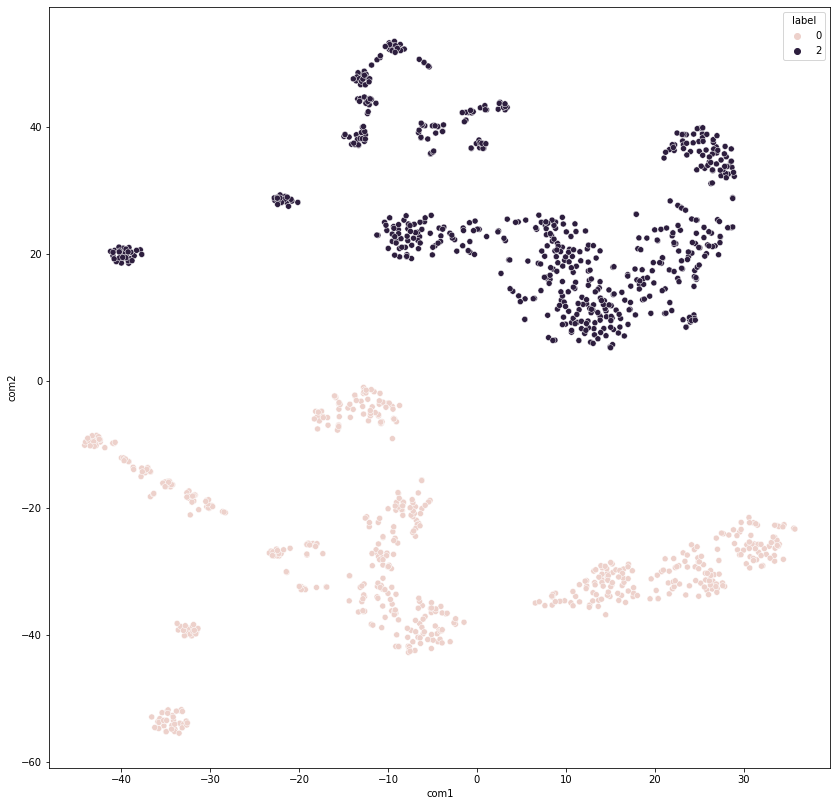

In [11]:
tsne = TSNE(n_components=2)
tt = tsne.fit_transform(mfcc_train)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train.iloc[:,2]

sns.set_palette('deep')
plt.figure(figsize=(14,14))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

---
# 3. Dataset & DataLoader
---

In [12]:
class custom_dataset(Dataset):
  
  def __init__(self, data):

    self.data = data

  def __len__(self):
    return len(self.data)
    

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.data[idx])
    return x


In [13]:
# mel
mel_train_dataset = custom_dataset(mel_train)
mel_train_loader = DataLoader(dataset = mel_train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

mel_test_dataset = custom_dataset(mel_test)
mel_test_loader = DataLoader(dataset = mel_test_dataset, batch_size = config.batch_size, shuffle = False, drop_last = False)

# mfcc 
mfcc_train_dataset = custom_dataset(mfcc_train)
mfcc_train_loader = DataLoader(dataset = mfcc_train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

mfcc_test_dataset = custom_dataset(mfcc_test)
mfcc_test_loader = DataLoader(dataset = mfcc_test_dataset, batch_size = config.batch_size, shuffle = False, drop_last = False)


---
# 4. Model
----

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim = 4):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 32),
            nn.Linear(32, 2 * latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.Linear(32, 128),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = x[:, : self.latent_dim  ], x[:, self.latent_dim  : ]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [15]:
mel_model = VAE().to(device)
mfcc_model = VAE().to(device)

mel_loss_fn = nn.BCELoss(size_average=False)
mfcc_loss_fn = nn.BCELoss(size_average=False)

mel_optimizer = optim.Adam(mel_model.parameters(), lr = config.lr)
mfcc_optimizer = optim.Adam(mfcc_model.parameters(), lr = config.lr)

In [16]:
for i in mel_train_loader:
  print(i.shape)
  break

torch.Size([64, 128])


---
# 5. Train
---

In [17]:
def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    for x in tqdm(data_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, log_var = model(x)
        recon_loss = loss_fn(x_recon, x)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(data_loader)

In [18]:
mel_graph_loss = []
mfcc_graph_loss = []

for epoch in range(config.epoch):
  
  mel_loss = train(mel_model,mel_train_loader, mel_loss_fn, mel_optimizer, device)
  mel_graph_loss.append(mel_loss)
  print(f'Epoch : {epoch +1} mel_Loss : {mel_loss}')

  mfcc_loss = train(mfcc_model,mfcc_train_loader, mfcc_loss_fn, mfcc_optimizer, device)
  mfcc_graph_loss.append(mfcc_loss)
  print(f'Epoch : {epoch +1} mfcc_Loss : {mfcc_loss}')  
  

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1 mel_Loss : 5774.932177734375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1 mfcc_Loss : 31337020672.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 2 mel_Loss : 5692.791015625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 2 mfcc_Loss : 1657377856.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 3 mel_Loss : 5609.865795898438


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 3 mfcc_Loss : 861544774.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 4 mel_Loss : 5527.710375976562


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 4 mfcc_Loss : 671125078.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 5 mel_Loss : 5421.600073242187


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 5 mfcc_Loss : 563023764.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 6 mel_Loss : 5340.918701171875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 6 mfcc_Loss : 480681683.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 7 mel_Loss : 5249.985083007812


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 7 mfcc_Loss : 414902161.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 8 mel_Loss : 5159.008715820312


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 8 mfcc_Loss : 361603452.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 9 mel_Loss : 5062.999682617187


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 9 mfcc_Loss : 318353889.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 10 mel_Loss : 4950.4176025390625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 10 mfcc_Loss : 282168372.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 11 mel_Loss : 4809.6004638671875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 11 mfcc_Loss : 252565344.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 12 mel_Loss : 4678.2200927734375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 12 mfcc_Loss : 226780361.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 13 mel_Loss : 4565.457275390625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 13 mfcc_Loss : 205073528.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 14 mel_Loss : 4400.62490234375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 14 mfcc_Loss : 186711756.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 15 mel_Loss : 4221.487292480469


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 15 mfcc_Loss : 170742706.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 16 mel_Loss : 4080.9334350585937


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 16 mfcc_Loss : 156687747.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 17 mel_Loss : 3875.791296386719


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 17 mfcc_Loss : 144407806.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 18 mel_Loss : 3713.8543090820312


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 18 mfcc_Loss : 133796251.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 19 mel_Loss : 3484.711047363281


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 19 mfcc_Loss : 124008028.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 20 mel_Loss : 3289.1707153320312


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 20 mfcc_Loss : 115592956.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 21 mel_Loss : 3083.0255615234373


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 21 mfcc_Loss : 107920310.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 22 mel_Loss : 2891.4948852539064


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 22 mfcc_Loss : 100879477.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 23 mel_Loss : 2707.3681396484376


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 23 mfcc_Loss : 94708722.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 24 mel_Loss : 2497.2047485351563


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 24 mfcc_Loss : 89079653.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 25 mel_Loss : 2333.0744750976564


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 25 mfcc_Loss : 83944498.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 26 mel_Loss : 2177.332940673828


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 26 mfcc_Loss : 79051277.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 27 mel_Loss : 2005.5757629394532


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 27 mfcc_Loss : 74835842.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 28 mel_Loss : 1873.516796875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 28 mfcc_Loss : 70893929.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 29 mel_Loss : 1772.2623779296875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 29 mfcc_Loss : 67322456.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 30 mel_Loss : 1679.7306701660157


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 30 mfcc_Loss : 63924117.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 31 mel_Loss : 1561.802801513672


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 31 mfcc_Loss : 60830264.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 32 mel_Loss : 1498.53095703125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 32 mfcc_Loss : 57877611.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 33 mel_Loss : 1450.4301147460938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 33 mfcc_Loss : 55258954.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 34 mel_Loss : 1380.898095703125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 34 mfcc_Loss : 52754211.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 35 mel_Loss : 1351.2480773925781


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 35 mfcc_Loss : 50431372.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 36 mel_Loss : 1323.9863830566405


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 36 mfcc_Loss : 48171478.3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 37 mel_Loss : 1279.948223876953


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 37 mfcc_Loss : 46173360.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 38 mel_Loss : 1249.9385864257813


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 38 mfcc_Loss : 44259085.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 39 mel_Loss : 1232.4451782226563


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 39 mfcc_Loss : 42423877.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 40 mel_Loss : 1195.648944091797


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 40 mfcc_Loss : 40615161.1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 41 mel_Loss : 1194.7887023925782


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 41 mfcc_Loss : 38616904.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 42 mel_Loss : 1171.4988342285155


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 42 mfcc_Loss : 36930585.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 43 mel_Loss : 1155.5994018554688


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 43 mfcc_Loss : 35477612.3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 44 mel_Loss : 1141.6537353515625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 44 mfcc_Loss : 34145444.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 45 mel_Loss : 1128.74384765625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 45 mfcc_Loss : 32915594.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 46 mel_Loss : 1111.9293395996094


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 46 mfcc_Loss : 31689977.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 47 mel_Loss : 1110.9881225585937


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 47 mfcc_Loss : 30527976.7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 48 mel_Loss : 1100.4747924804688


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 48 mfcc_Loss : 29434320.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 49 mel_Loss : 1089.7141418457031


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 49 mfcc_Loss : 28387754.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 50 mel_Loss : 1077.712661743164


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 50 mfcc_Loss : 27381816.9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 51 mel_Loss : 1072.5863800048828


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 51 mfcc_Loss : 26462164.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 52 mel_Loss : 1066.8142150878907


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 52 mfcc_Loss : 25557956.9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 53 mel_Loss : 1053.5872894287108


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 53 mfcc_Loss : 24714047.1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 54 mel_Loss : 1048.0521728515625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 54 mfcc_Loss : 23911661.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 55 mel_Loss : 1039.1672607421874


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 55 mfcc_Loss : 23130897.55


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 56 mel_Loss : 1025.6378967285157


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 56 mfcc_Loss : 22382208.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 57 mel_Loss : 1025.2054412841796


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 57 mfcc_Loss : 21690617.7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 58 mel_Loss : 1019.6268310546875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 58 mfcc_Loss : 21008538.35


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 59 mel_Loss : 1017.025357055664


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 59 mfcc_Loss : 20364141.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 60 mel_Loss : 1007.7886108398437


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 60 mfcc_Loss : 19738995.15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 61 mel_Loss : 1000.6832885742188


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 61 mfcc_Loss : 19153166.15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 62 mel_Loss : 994.8931427001953


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 62 mfcc_Loss : 18588644.75


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 63 mel_Loss : 990.8492370605469


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 63 mfcc_Loss : 18032872.45


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 64 mel_Loss : 984.6869476318359


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 64 mfcc_Loss : 17502135.55


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 65 mel_Loss : 972.6738494873047


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 65 mfcc_Loss : 17000829.6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 66 mel_Loss : 977.6240509033203


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 66 mfcc_Loss : 16505131.15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 67 mel_Loss : 963.6925903320313


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 67 mfcc_Loss : 16042428.35


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 68 mel_Loss : 968.2588256835937


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 68 mfcc_Loss : 15582328.1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 69 mel_Loss : 956.7383270263672


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 69 mfcc_Loss : 15153021.2


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 70 mel_Loss : 954.9920135498047


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 70 mfcc_Loss : 14724797.95


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 71 mel_Loss : 951.8272735595704


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 71 mfcc_Loss : 14327708.7


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 72 mel_Loss : 935.6062469482422


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 72 mfcc_Loss : 13929734.25


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 73 mel_Loss : 940.2283142089843


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 73 mfcc_Loss : 13551076.3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 74 mel_Loss : 938.0229644775391


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 74 mfcc_Loss : 13194003.1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 75 mel_Loss : 935.5014678955079


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 75 mfcc_Loss : 12836606.95


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 76 mel_Loss : 932.6947784423828


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 76 mfcc_Loss : 12495850.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 77 mel_Loss : 927.3565399169922


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 77 mfcc_Loss : 12162855.25


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 78 mel_Loss : 928.5128143310546


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 78 mfcc_Loss : 11840222.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 79 mel_Loss : 926.795751953125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 79 mfcc_Loss : 11527404.9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 80 mel_Loss : 916.7190002441406


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 80 mfcc_Loss : 11231816.425


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 81 mel_Loss : 902.7155212402344


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 81 mfcc_Loss : 10934977.75


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 82 mel_Loss : 905.1524017333984


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 82 mfcc_Loss : 10658924.9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 83 mel_Loss : 900.941781616211


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 83 mfcc_Loss : 10377471.75


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 84 mel_Loss : 903.1656524658204


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 84 mfcc_Loss : 10127417.45


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 85 mel_Loss : 906.528286743164


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 85 mfcc_Loss : 9864272.575


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 86 mel_Loss : 896.7724182128907


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 86 mfcc_Loss : 9623214.875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 87 mel_Loss : 892.4166656494141


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 87 mfcc_Loss : 9378073.325


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 88 mel_Loss : 901.15048828125


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 88 mfcc_Loss : 9146650.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 89 mel_Loss : 878.116909790039


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 89 mfcc_Loss : 8918833.075


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 90 mel_Loss : 874.8368072509766


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 90 mfcc_Loss : 8699756.975


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 91 mel_Loss : 876.72509765625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 91 mfcc_Loss : 8483143.375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 92 mel_Loss : 873.7028442382813


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 92 mfcc_Loss : 8272811.475


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 93 mel_Loss : 868.4392822265625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 93 mfcc_Loss : 8074210.3


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 94 mel_Loss : 875.9242706298828


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 94 mfcc_Loss : 7878873.85


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 95 mel_Loss : 870.7142181396484


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 95 mfcc_Loss : 7671160.8


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 96 mel_Loss : 870.9044494628906


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 96 mfcc_Loss : 7504911.4


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 97 mel_Loss : 869.7480895996093


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 97 mfcc_Loss : 7313004.85


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 98 mel_Loss : 861.244384765625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 98 mfcc_Loss : 7135283.45


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 99 mel_Loss : 863.4752624511718


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 99 mfcc_Loss : 6959452.75


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 100 mel_Loss : 869.2661346435547


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 100 mfcc_Loss : 6798769.425


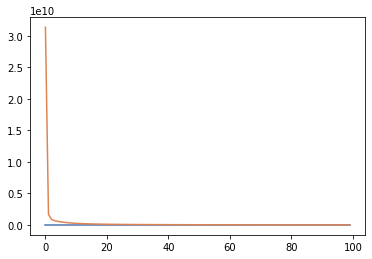

In [19]:
plt.plot(mel_graph_loss)
plt.plot(mfcc_graph_loss)

---
# 6. Prediction
----

In [20]:
def test(model, data_loader, loss_fn, device):

  scores = []
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for x in tqdm(data_loader):
      x = x.to(device)
      x_recon, mu, log_var = model(x)
      recon_loss = loss_fn(x_recon, x)
      kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
      loss = recon_loss + kl_loss
      test_loss += loss.item()

      score = torch.mean(torch.abs(x - x_recon), axis = 1)
      scores.extend(score.cpu().numpy())

  return np.array(scores)


In [30]:
train_scores = test(mel_model, mel_train_loader, mel_loss_fn, device)
test_scores = test(mel_model, mel_test_loader, mel_loss_fn, device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [22]:
train_scores = test(mfcc_model, mfcc_train_loader, mfcc_loss_fn, device)
test_scores = test(mfcc_model, mfcc_test_loader, mfcc_loss_fn, device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [23]:
threshold = train_scores.max()
threshold

6.751383

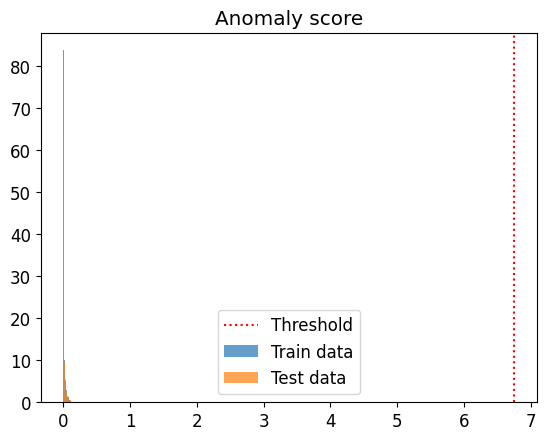

In [31]:
# 히스토그램
plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_scores, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_scores, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=threshold, c='red', linestyle=':', label='Threshold')
plt.title("Anomaly score")
plt.legend()

In [32]:
def get_pred_label(model_pred, t):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= t, 0, model_pred)
    model_pred = np.where(model_pred > t, 1, model_pred)
    return model_pred

In [33]:
train_pred = get_pred_label(train_scores, threshold)
Counter(train_pred)

Counter({0.0: 1279})

In [34]:
test_pred = get_pred_label(test_scores, threshold)
Counter(test_pred)

Counter({0.0: 1514})

---
# 7. Submisson
---

In [28]:
sub = pd.read_csv(config.sub)
sub['LABEL'] = test_pred
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,0.0
3,TEST_0003,1.0
4,TEST_0004,0.0
...,...,...
1509,TEST_1509,1.0
1510,TEST_1510,0.0
1511,TEST_1511,0.0
1512,TEST_1512,0.0


In [29]:
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0127_VAE.csv', index = False)